# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

#helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

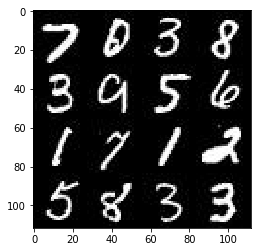

In [2]:
show_n_images = 16

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

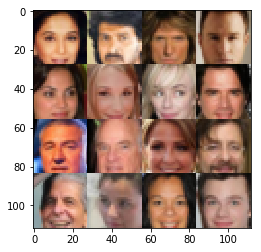

In [3]:
show_n_images = 16

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.1
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    
    image = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels))
    z_input = tf.placeholder(tf.float32, (None, z_dim))
    lr = tf.placeholder(tf.float32, ()) #lr is just a constant
    #print('image_batch size: ',image.get_shape().as_list())
    #print('z_input size: ',z_input.get_shape().as_list())
    #print('lr size: ',lr.get_shape().as_list())
    
    return image, z_input, lr

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # create 3 conv layers & 1 fc layer
    # alpha is the value for lrelu, set to a constant
    alpha = 0.2
    
    with tf.variable_scope('discriminator', reuse=reuse):
            #first input layer is 28x28x1 (mnist) or 28*28*3 (celebA)
            ###print('image input shape: ', images.get_shape().as_list())
            conv1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
            ###print('conv1 layer output shape: ', conv1.get_shape().as_list())
            #no batch norm for 1st conv layer
            relu1 = tf.maximum(alpha*conv1, conv1)
            # relu1 is 14x14x64
            
            conv2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
            ###print('conv2 layer output shape: ', conv2.get_shape().as_list())
            bn2 = tf.layers.batch_normalization(conv2, training=True)
            relu2 = tf.maximum(alpha*bn2, bn2)
            # relu1 is 7x7x128
            
            conv3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
            ###print('conv3 layer output shape: ', conv3.get_shape().as_list())
            bn3 = tf.layers.batch_normalization(conv3, training=True)
            relu3 = tf.maximum(alpha*bn2, bn2)
            # relu1 is 4x4x256
            
            #flatten the layer
            flat = tf.reshape(relu3, (-1,4*4*256))
            logits = tf.layers.dense(flat,1)
            out = tf.sigmoid(logits)

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # create 1 fc layer, 3 conv layers & 1 output layer
    # alpha is the value for lrelu, set to a constant
    alpha = 0.2
    
    with tf.variable_scope('generator', reuse=not is_train):
        
        #create first fc layer
        fc1 = tf.layers.dense(z, 4*4*512)
        ###print('fc1 layer output shape: ', fc1.get_shape().as_list())
        #fc1 is 28*28*out_channel_dim (for the test case it's 28*28*5 = 3920)
        
        #reshape fc1 to start the generator 
        conv1 = tf.reshape(fc1, (-1,4,4,512))
        ###print('conv1 layer output shape: ', conv1.get_shape().as_list())
        conv1 = tf.layers.batch_normalization(conv1, training=is_train)
        relu1 = tf.maximum(alpha*conv1, conv1)
        #relu1 is 4x4x512
        
        #conv layer 2
        conv2 = tf.layers.conv2d_transpose(relu1, 256, 4, strides=1, padding='valid')
        ###print('conv2 layer output shape: ', conv2.get_shape().as_list())
        conv2 = tf.layers.batch_normalization(conv2, training=is_train)
        relu2 = tf.maximum(alpha*conv2, conv2)
        #relu2 is 7x7x256
        
        #conv layer3
        conv3 = tf.layers.conv2d_transpose(relu2, 128, 5, strides=2, padding='same')
        ###print('conv3 layer output shape: ', conv3.get_shape().as_list())
        conv3 = tf.layers.batch_normalization(conv3, training=is_train)
        relu3 = tf.maximum(alpha*conv3, conv3)
        #relu3 is 14x14x128
        
        #output layer
        logits = tf.layers.conv2d_transpose(relu3, out_channel_dim, 5, strides=2, padding='same')
        ###print('output layer shape: ', logits.get_shape().as_list())
        #logits is 28x28xout_channel_dim
        
        out = tf.tanh(logits)
        
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)*0.9))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    #get weights and bias that needs updating
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    # Optimization
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [13]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    print_every = 20
    show_every = 200
    
    #create placeholders
    image_batch, z_input, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    #print('image_batch size: ',image_batch.get_shape().as_list())
    #print('z_input size: ',z_input.get_shape().as_list())
    #print('lr size: ',lr.get_shape().as_list())
    
    #create d & g loss functions
    d_loss, g_loss = model_loss(image_batch, z_input, data_shape[3])
    #print('d_loss size: ',d_loss.get_shape().as_list())
    #print('g_loss size: ',g_loss.get_shape().as_list())
    
    #create function to optimize d & g training
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
       
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            
            #to keep track of every batch in every epoch
            batch_num = 0 
            
            for batch_images in get_batches(batch_size):
                
                batch_num+=1
                
                #to rescale to -1 to 1 because of tanh
                batch_images = batch_images*2
                
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                #print('batch_z size: ',batch_z.shape )
                #print('batch_images size: ',batch_images.shape )
                
                # Run optimizers
                # Optimize Discriminator
                #print('batch_images size: ',batch_images.get_shape().as_list())
                _ = sess.run(d_train_opt, feed_dict={image_batch: batch_images, z_input: batch_z, lr: learning_rate}) #problem
                # Optimize Generator twice
                _ = sess.run(g_train_opt, feed_dict={image_batch: batch_images, z_input: batch_z, lr: learning_rate})
                _ = sess.run(g_train_opt, feed_dict={image_batch: batch_images, z_input: batch_z, lr: learning_rate})
               
                #find losses and print values every print_every
                if batch_num % print_every == 0:
                    
                    train_loss_d = d_loss.eval({image_batch: batch_images, z_input: batch_z})
                    train_loss_g = g_loss.eval({image_batch: batch_images, z_input: batch_z})
                    
                    #print the stats and losses
                    print("Epoch {}/{}, ".format(epoch_i+1, epochs),
                          "Batch {}, ".format(batch_num),
                          "Discriminator Loss: {:.4f}, ".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    
                if batch_num % show_every == 0:
                    show_generator_output(sess, 16, z_input, data_shape[3], data_image_mode)
                    
                    
        show_generator_output(sess, 16, z_input, data_shape[3], data_image_mode)           
        print('GAN is completed.')
                    
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2,  Batch 20,  Discriminator Loss: 1.8388,  Generator Loss: 0.3523
Epoch 1/2,  Batch 40,  Discriminator Loss: 1.5339,  Generator Loss: 0.5270
Epoch 1/2,  Batch 60,  Discriminator Loss: 1.5656,  Generator Loss: 0.4924
Epoch 1/2,  Batch 80,  Discriminator Loss: 1.4097,  Generator Loss: 0.6656
Epoch 1/2,  Batch 100,  Discriminator Loss: 1.3307,  Generator Loss: 0.7014
Epoch 1/2,  Batch 120,  Discriminator Loss: 1.2757,  Generator Loss: 0.7444
Epoch 1/2,  Batch 140,  Discriminator Loss: 1.3564,  Generator Loss: 0.7077
Epoch 1/2,  Batch 160,  Discriminator Loss: 1.3925,  Generator Loss: 0.6973
Epoch 1/2,  Batch 180,  Discriminator Loss: 1.3371,  Generator Loss: 0.7207
Epoch 1/2,  Batch 200,  Discriminator Loss: 1.3054,  Generator Loss: 0.7545


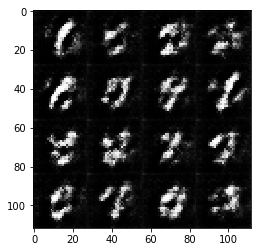

Epoch 1/2,  Batch 220,  Discriminator Loss: 1.2676,  Generator Loss: 0.8115
Epoch 1/2,  Batch 240,  Discriminator Loss: 1.3341,  Generator Loss: 0.7282
Epoch 1/2,  Batch 260,  Discriminator Loss: 1.2409,  Generator Loss: 0.8210
Epoch 1/2,  Batch 280,  Discriminator Loss: 1.4198,  Generator Loss: 0.7088
Epoch 1/2,  Batch 300,  Discriminator Loss: 1.2595,  Generator Loss: 0.8489
Epoch 1/2,  Batch 320,  Discriminator Loss: 1.2558,  Generator Loss: 0.8234
Epoch 1/2,  Batch 340,  Discriminator Loss: 1.3200,  Generator Loss: 0.7767
Epoch 1/2,  Batch 360,  Discriminator Loss: 1.3108,  Generator Loss: 0.8217
Epoch 1/2,  Batch 380,  Discriminator Loss: 1.2773,  Generator Loss: 0.8286
Epoch 1/2,  Batch 400,  Discriminator Loss: 1.3012,  Generator Loss: 0.8401


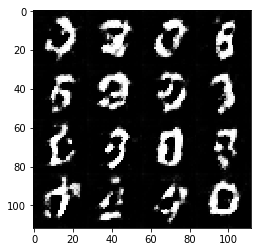

Epoch 1/2,  Batch 420,  Discriminator Loss: 1.1758,  Generator Loss: 0.8990
Epoch 1/2,  Batch 440,  Discriminator Loss: 1.1986,  Generator Loss: 0.8389
Epoch 1/2,  Batch 460,  Discriminator Loss: 1.2851,  Generator Loss: 0.8218
Epoch 1/2,  Batch 480,  Discriminator Loss: 1.2579,  Generator Loss: 0.8625
Epoch 1/2,  Batch 500,  Discriminator Loss: 1.2985,  Generator Loss: 0.8086
Epoch 1/2,  Batch 520,  Discriminator Loss: 1.2784,  Generator Loss: 0.8132
Epoch 1/2,  Batch 540,  Discriminator Loss: 1.2775,  Generator Loss: 0.8328
Epoch 1/2,  Batch 560,  Discriminator Loss: 1.2398,  Generator Loss: 0.8760
Epoch 1/2,  Batch 580,  Discriminator Loss: 1.2521,  Generator Loss: 0.8116
Epoch 1/2,  Batch 600,  Discriminator Loss: 1.2681,  Generator Loss: 0.8374


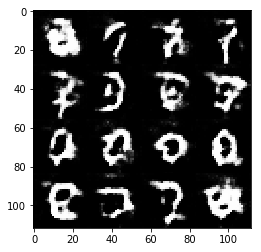

Epoch 1/2,  Batch 620,  Discriminator Loss: 1.2849,  Generator Loss: 0.8504
Epoch 1/2,  Batch 640,  Discriminator Loss: 1.2597,  Generator Loss: 0.8534
Epoch 1/2,  Batch 660,  Discriminator Loss: 1.2475,  Generator Loss: 0.8807
Epoch 1/2,  Batch 680,  Discriminator Loss: 1.2782,  Generator Loss: 0.8101
Epoch 1/2,  Batch 700,  Discriminator Loss: 1.1792,  Generator Loss: 0.9447
Epoch 1/2,  Batch 720,  Discriminator Loss: 1.2538,  Generator Loss: 0.8795
Epoch 1/2,  Batch 740,  Discriminator Loss: 1.2097,  Generator Loss: 0.8431
Epoch 1/2,  Batch 760,  Discriminator Loss: 1.1568,  Generator Loss: 0.8963
Epoch 1/2,  Batch 780,  Discriminator Loss: 1.2195,  Generator Loss: 0.8839
Epoch 1/2,  Batch 800,  Discriminator Loss: 1.3109,  Generator Loss: 0.8354


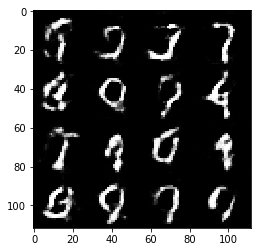

Epoch 1/2,  Batch 820,  Discriminator Loss: 1.2358,  Generator Loss: 0.8765
Epoch 1/2,  Batch 840,  Discriminator Loss: 1.2032,  Generator Loss: 0.8734
Epoch 1/2,  Batch 860,  Discriminator Loss: 1.2157,  Generator Loss: 0.8823
Epoch 1/2,  Batch 880,  Discriminator Loss: 1.3015,  Generator Loss: 0.8736
Epoch 1/2,  Batch 900,  Discriminator Loss: 1.2307,  Generator Loss: 0.8566
Epoch 1/2,  Batch 920,  Discriminator Loss: 1.2505,  Generator Loss: 0.8869
Epoch 1/2,  Batch 940,  Discriminator Loss: 1.2808,  Generator Loss: 0.7977
Epoch 1/2,  Batch 960,  Discriminator Loss: 1.2841,  Generator Loss: 0.8511
Epoch 1/2,  Batch 980,  Discriminator Loss: 1.2685,  Generator Loss: 0.8082
Epoch 1/2,  Batch 1000,  Discriminator Loss: 1.2891,  Generator Loss: 0.8178


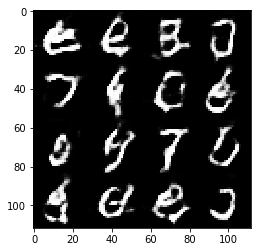

Epoch 1/2,  Batch 1020,  Discriminator Loss: 1.2908,  Generator Loss: 0.8316
Epoch 1/2,  Batch 1040,  Discriminator Loss: 1.3228,  Generator Loss: 0.7925
Epoch 1/2,  Batch 1060,  Discriminator Loss: 1.2645,  Generator Loss: 0.8125
Epoch 1/2,  Batch 1080,  Discriminator Loss: 1.2230,  Generator Loss: 0.8941
Epoch 1/2,  Batch 1100,  Discriminator Loss: 1.2595,  Generator Loss: 0.8555
Epoch 1/2,  Batch 1120,  Discriminator Loss: 1.2729,  Generator Loss: 0.9067
Epoch 1/2,  Batch 1140,  Discriminator Loss: 1.3058,  Generator Loss: 0.8255
Epoch 1/2,  Batch 1160,  Discriminator Loss: 1.2579,  Generator Loss: 0.8512
Epoch 1/2,  Batch 1180,  Discriminator Loss: 1.2508,  Generator Loss: 0.8280
Epoch 1/2,  Batch 1200,  Discriminator Loss: 1.2162,  Generator Loss: 0.8745


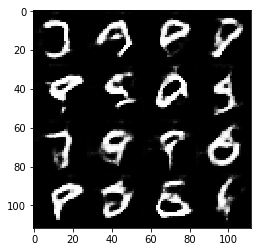

Epoch 1/2,  Batch 1220,  Discriminator Loss: 1.2928,  Generator Loss: 0.8514
Epoch 1/2,  Batch 1240,  Discriminator Loss: 1.2887,  Generator Loss: 0.8636
Epoch 1/2,  Batch 1260,  Discriminator Loss: 1.1752,  Generator Loss: 0.9057
Epoch 1/2,  Batch 1280,  Discriminator Loss: 1.2723,  Generator Loss: 0.8715
Epoch 1/2,  Batch 1300,  Discriminator Loss: 1.2417,  Generator Loss: 0.8936
Epoch 1/2,  Batch 1320,  Discriminator Loss: 1.2704,  Generator Loss: 0.8298
Epoch 1/2,  Batch 1340,  Discriminator Loss: 1.2332,  Generator Loss: 0.8622
Epoch 1/2,  Batch 1360,  Discriminator Loss: 1.3691,  Generator Loss: 0.7613
Epoch 1/2,  Batch 1380,  Discriminator Loss: 1.2833,  Generator Loss: 0.8152
Epoch 1/2,  Batch 1400,  Discriminator Loss: 1.3118,  Generator Loss: 0.8680


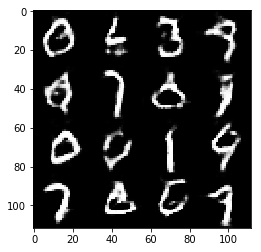

Epoch 1/2,  Batch 1420,  Discriminator Loss: 1.2669,  Generator Loss: 0.8102
Epoch 1/2,  Batch 1440,  Discriminator Loss: 1.2400,  Generator Loss: 0.8817
Epoch 1/2,  Batch 1460,  Discriminator Loss: 1.2574,  Generator Loss: 0.8544
Epoch 1/2,  Batch 1480,  Discriminator Loss: 1.2416,  Generator Loss: 0.8346
Epoch 1/2,  Batch 1500,  Discriminator Loss: 1.2381,  Generator Loss: 0.8389
Epoch 1/2,  Batch 1520,  Discriminator Loss: 1.1849,  Generator Loss: 0.9019
Epoch 1/2,  Batch 1540,  Discriminator Loss: 1.2338,  Generator Loss: 0.8497
Epoch 1/2,  Batch 1560,  Discriminator Loss: 1.2180,  Generator Loss: 0.8693
Epoch 1/2,  Batch 1580,  Discriminator Loss: 1.2466,  Generator Loss: 0.8884
Epoch 1/2,  Batch 1600,  Discriminator Loss: 1.2753,  Generator Loss: 0.7913


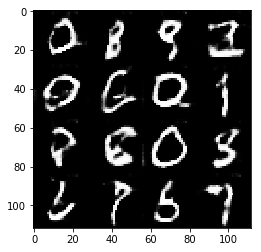

Epoch 1/2,  Batch 1620,  Discriminator Loss: 1.2315,  Generator Loss: 0.8967
Epoch 1/2,  Batch 1640,  Discriminator Loss: 1.2544,  Generator Loss: 0.8616
Epoch 1/2,  Batch 1660,  Discriminator Loss: 1.2271,  Generator Loss: 0.9422
Epoch 1/2,  Batch 1680,  Discriminator Loss: 1.1671,  Generator Loss: 0.9744
Epoch 1/2,  Batch 1700,  Discriminator Loss: 1.2459,  Generator Loss: 0.9074
Epoch 1/2,  Batch 1720,  Discriminator Loss: 1.3929,  Generator Loss: 0.7563
Epoch 1/2,  Batch 1740,  Discriminator Loss: 1.2518,  Generator Loss: 0.8025
Epoch 1/2,  Batch 1760,  Discriminator Loss: 1.2223,  Generator Loss: 0.7959
Epoch 1/2,  Batch 1780,  Discriminator Loss: 1.2115,  Generator Loss: 0.9896
Epoch 1/2,  Batch 1800,  Discriminator Loss: 1.1927,  Generator Loss: 0.8583


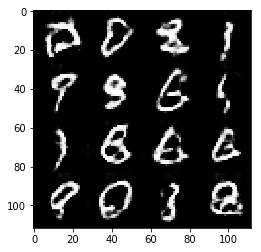

Epoch 1/2,  Batch 1820,  Discriminator Loss: 1.2090,  Generator Loss: 0.8372
Epoch 1/2,  Batch 1840,  Discriminator Loss: 1.2542,  Generator Loss: 0.8595
Epoch 1/2,  Batch 1860,  Discriminator Loss: 1.1960,  Generator Loss: 0.9191
Epoch 2/2,  Batch 20,  Discriminator Loss: 1.1844,  Generator Loss: 0.8426
Epoch 2/2,  Batch 40,  Discriminator Loss: 1.1678,  Generator Loss: 0.8963
Epoch 2/2,  Batch 60,  Discriminator Loss: 1.2187,  Generator Loss: 0.9923
Epoch 2/2,  Batch 80,  Discriminator Loss: 1.1657,  Generator Loss: 0.8883
Epoch 2/2,  Batch 100,  Discriminator Loss: 1.1812,  Generator Loss: 0.8955
Epoch 2/2,  Batch 120,  Discriminator Loss: 1.2340,  Generator Loss: 0.8711
Epoch 2/2,  Batch 140,  Discriminator Loss: 1.2280,  Generator Loss: 0.9105
Epoch 2/2,  Batch 160,  Discriminator Loss: 1.1857,  Generator Loss: 0.8739
Epoch 2/2,  Batch 180,  Discriminator Loss: 1.1797,  Generator Loss: 0.8313
Epoch 2/2,  Batch 200,  Discriminator Loss: 1.1991,  Generator Loss: 0.8401


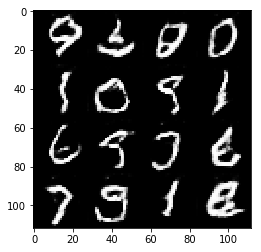

Epoch 2/2,  Batch 220,  Discriminator Loss: 1.1956,  Generator Loss: 0.9281
Epoch 2/2,  Batch 240,  Discriminator Loss: 1.2022,  Generator Loss: 0.9481
Epoch 2/2,  Batch 260,  Discriminator Loss: 1.1575,  Generator Loss: 0.9262
Epoch 2/2,  Batch 280,  Discriminator Loss: 1.1671,  Generator Loss: 0.8856
Epoch 2/2,  Batch 300,  Discriminator Loss: 1.2407,  Generator Loss: 0.7896
Epoch 2/2,  Batch 320,  Discriminator Loss: 1.2616,  Generator Loss: 0.8533
Epoch 2/2,  Batch 340,  Discriminator Loss: 1.2015,  Generator Loss: 0.9005
Epoch 2/2,  Batch 360,  Discriminator Loss: 1.1882,  Generator Loss: 0.9260
Epoch 2/2,  Batch 380,  Discriminator Loss: 1.1431,  Generator Loss: 0.9618
Epoch 2/2,  Batch 400,  Discriminator Loss: 1.1475,  Generator Loss: 0.9261


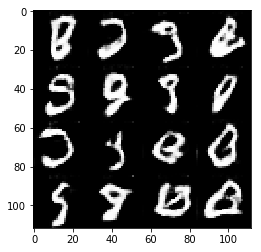

Epoch 2/2,  Batch 420,  Discriminator Loss: 1.1648,  Generator Loss: 0.8568
Epoch 2/2,  Batch 440,  Discriminator Loss: 1.1711,  Generator Loss: 0.8661
Epoch 2/2,  Batch 460,  Discriminator Loss: 1.2352,  Generator Loss: 0.8848
Epoch 2/2,  Batch 480,  Discriminator Loss: 1.1941,  Generator Loss: 1.0207
Epoch 2/2,  Batch 500,  Discriminator Loss: 1.1441,  Generator Loss: 0.8850
Epoch 2/2,  Batch 520,  Discriminator Loss: 1.1187,  Generator Loss: 0.8184
Epoch 2/2,  Batch 540,  Discriminator Loss: 1.1870,  Generator Loss: 1.0033
Epoch 2/2,  Batch 560,  Discriminator Loss: 1.1888,  Generator Loss: 0.8440
Epoch 2/2,  Batch 580,  Discriminator Loss: 1.1533,  Generator Loss: 0.9792
Epoch 2/2,  Batch 600,  Discriminator Loss: 1.2036,  Generator Loss: 0.9268


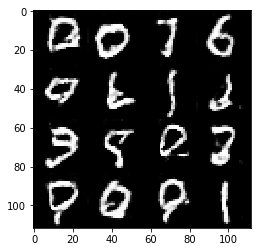

Epoch 2/2,  Batch 620,  Discriminator Loss: 1.2170,  Generator Loss: 1.0572
Epoch 2/2,  Batch 640,  Discriminator Loss: 1.1551,  Generator Loss: 0.9727
Epoch 2/2,  Batch 660,  Discriminator Loss: 1.2177,  Generator Loss: 0.8786
Epoch 2/2,  Batch 680,  Discriminator Loss: 1.1349,  Generator Loss: 1.0590
Epoch 2/2,  Batch 700,  Discriminator Loss: 1.1151,  Generator Loss: 0.9648
Epoch 2/2,  Batch 720,  Discriminator Loss: 1.1544,  Generator Loss: 0.9179
Epoch 2/2,  Batch 740,  Discriminator Loss: 1.1346,  Generator Loss: 0.9429
Epoch 2/2,  Batch 760,  Discriminator Loss: 1.1283,  Generator Loss: 0.9542
Epoch 2/2,  Batch 780,  Discriminator Loss: 1.1147,  Generator Loss: 1.0103
Epoch 2/2,  Batch 800,  Discriminator Loss: 1.1605,  Generator Loss: 1.0155


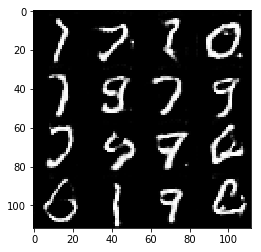

Epoch 2/2,  Batch 820,  Discriminator Loss: 1.0834,  Generator Loss: 1.0619
Epoch 2/2,  Batch 840,  Discriminator Loss: 1.1019,  Generator Loss: 0.9386
Epoch 2/2,  Batch 860,  Discriminator Loss: 1.1800,  Generator Loss: 0.8032
Epoch 2/2,  Batch 880,  Discriminator Loss: 1.2468,  Generator Loss: 0.7293
Epoch 2/2,  Batch 900,  Discriminator Loss: 1.0916,  Generator Loss: 0.9638
Epoch 2/2,  Batch 920,  Discriminator Loss: 1.1279,  Generator Loss: 1.1545
Epoch 2/2,  Batch 940,  Discriminator Loss: 1.1943,  Generator Loss: 0.8080
Epoch 2/2,  Batch 960,  Discriminator Loss: 1.1001,  Generator Loss: 0.9597
Epoch 2/2,  Batch 980,  Discriminator Loss: 1.0854,  Generator Loss: 0.9718
Epoch 2/2,  Batch 1000,  Discriminator Loss: 1.1199,  Generator Loss: 0.8780


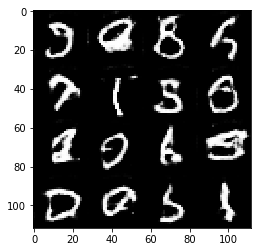

Epoch 2/2,  Batch 1020,  Discriminator Loss: 1.3061,  Generator Loss: 0.8085
Epoch 2/2,  Batch 1040,  Discriminator Loss: 1.1360,  Generator Loss: 0.9653
Epoch 2/2,  Batch 1060,  Discriminator Loss: 1.1128,  Generator Loss: 1.1600
Epoch 2/2,  Batch 1080,  Discriminator Loss: 1.1267,  Generator Loss: 0.8284
Epoch 2/2,  Batch 1100,  Discriminator Loss: 1.0083,  Generator Loss: 1.0123
Epoch 2/2,  Batch 1120,  Discriminator Loss: 1.2779,  Generator Loss: 0.6817
Epoch 2/2,  Batch 1140,  Discriminator Loss: 1.1764,  Generator Loss: 0.9214
Epoch 2/2,  Batch 1160,  Discriminator Loss: 1.1362,  Generator Loss: 1.1097
Epoch 2/2,  Batch 1180,  Discriminator Loss: 1.1093,  Generator Loss: 0.9351
Epoch 2/2,  Batch 1200,  Discriminator Loss: 1.1785,  Generator Loss: 0.9129


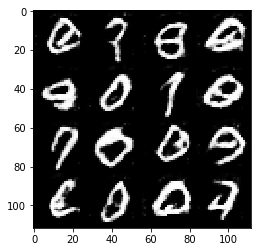

Epoch 2/2,  Batch 1220,  Discriminator Loss: 1.2195,  Generator Loss: 1.0317
Epoch 2/2,  Batch 1240,  Discriminator Loss: 1.0860,  Generator Loss: 0.9363
Epoch 2/2,  Batch 1260,  Discriminator Loss: 1.0400,  Generator Loss: 1.1200
Epoch 2/2,  Batch 1280,  Discriminator Loss: 1.1134,  Generator Loss: 1.1451
Epoch 2/2,  Batch 1300,  Discriminator Loss: 1.1063,  Generator Loss: 1.1385
Epoch 2/2,  Batch 1320,  Discriminator Loss: 1.1327,  Generator Loss: 0.9335
Epoch 2/2,  Batch 1340,  Discriminator Loss: 1.1226,  Generator Loss: 1.1405
Epoch 2/2,  Batch 1360,  Discriminator Loss: 1.2105,  Generator Loss: 0.9734
Epoch 2/2,  Batch 1380,  Discriminator Loss: 1.1597,  Generator Loss: 0.8641
Epoch 2/2,  Batch 1400,  Discriminator Loss: 1.1813,  Generator Loss: 0.9627


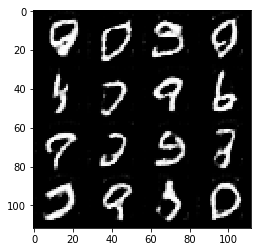

Epoch 2/2,  Batch 1420,  Discriminator Loss: 1.1190,  Generator Loss: 1.0033
Epoch 2/2,  Batch 1440,  Discriminator Loss: 1.1794,  Generator Loss: 0.8940
Epoch 2/2,  Batch 1460,  Discriminator Loss: 1.1049,  Generator Loss: 0.9268
Epoch 2/2,  Batch 1480,  Discriminator Loss: 1.1061,  Generator Loss: 1.0712
Epoch 2/2,  Batch 1500,  Discriminator Loss: 1.0796,  Generator Loss: 0.9186
Epoch 2/2,  Batch 1520,  Discriminator Loss: 1.0686,  Generator Loss: 1.1100
Epoch 2/2,  Batch 1540,  Discriminator Loss: 1.0641,  Generator Loss: 1.1579
Epoch 2/2,  Batch 1560,  Discriminator Loss: 1.1691,  Generator Loss: 0.8901
Epoch 2/2,  Batch 1580,  Discriminator Loss: 1.1489,  Generator Loss: 1.1101
Epoch 2/2,  Batch 1600,  Discriminator Loss: 1.1472,  Generator Loss: 0.9235


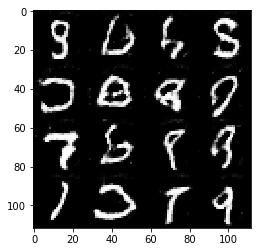

Epoch 2/2,  Batch 1620,  Discriminator Loss: 1.1197,  Generator Loss: 1.0051
Epoch 2/2,  Batch 1640,  Discriminator Loss: 1.1580,  Generator Loss: 0.8417
Epoch 2/2,  Batch 1660,  Discriminator Loss: 1.0401,  Generator Loss: 1.0896
Epoch 2/2,  Batch 1680,  Discriminator Loss: 1.2797,  Generator Loss: 0.7746
Epoch 2/2,  Batch 1700,  Discriminator Loss: 1.0805,  Generator Loss: 0.9605
Epoch 2/2,  Batch 1720,  Discriminator Loss: 1.3122,  Generator Loss: 0.9611
Epoch 2/2,  Batch 1740,  Discriminator Loss: 1.2843,  Generator Loss: 0.9742
Epoch 2/2,  Batch 1760,  Discriminator Loss: 1.0628,  Generator Loss: 1.1411
Epoch 2/2,  Batch 1780,  Discriminator Loss: 1.0156,  Generator Loss: 1.0419
Epoch 2/2,  Batch 1800,  Discriminator Loss: 1.0726,  Generator Loss: 1.0001


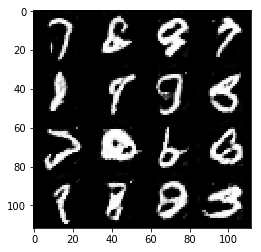

Epoch 2/2,  Batch 1820,  Discriminator Loss: 1.1084,  Generator Loss: 1.0327
Epoch 2/2,  Batch 1840,  Discriminator Loss: 1.1114,  Generator Loss: 0.9782
Epoch 2/2,  Batch 1860,  Discriminator Loss: 1.1851,  Generator Loss: 0.9908


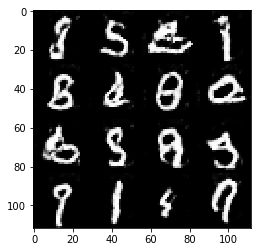

GAN is completed.


In [12]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1,  Batch 20,  Discriminator Loss: 4.3416,  Generator Loss: 0.0297
Epoch 1/1,  Batch 40,  Discriminator Loss: 3.8085,  Generator Loss: 0.0496
Epoch 1/1,  Batch 60,  Discriminator Loss: 3.1439,  Generator Loss: 0.0901
Epoch 1/1,  Batch 80,  Discriminator Loss: 2.4230,  Generator Loss: 0.1920
Epoch 1/1,  Batch 100,  Discriminator Loss: 1.7639,  Generator Loss: 0.4089
Epoch 1/1,  Batch 120,  Discriminator Loss: 1.6171,  Generator Loss: 0.5274
Epoch 1/1,  Batch 140,  Discriminator Loss: 1.4482,  Generator Loss: 0.6508
Epoch 1/1,  Batch 160,  Discriminator Loss: 1.4301,  Generator Loss: 0.6527
Epoch 1/1,  Batch 180,  Discriminator Loss: 1.3537,  Generator Loss: 0.7108
Epoch 1/1,  Batch 200,  Discriminator Loss: 1.2958,  Generator Loss: 0.7448


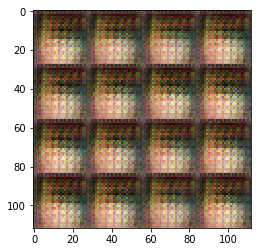

Epoch 1/1,  Batch 220,  Discriminator Loss: 1.1835,  Generator Loss: 0.8320
Epoch 1/1,  Batch 240,  Discriminator Loss: 1.2823,  Generator Loss: 0.7520
Epoch 1/1,  Batch 260,  Discriminator Loss: 1.1348,  Generator Loss: 0.8618
Epoch 1/1,  Batch 280,  Discriminator Loss: 1.1128,  Generator Loss: 0.9236
Epoch 1/1,  Batch 300,  Discriminator Loss: 1.2074,  Generator Loss: 0.7907
Epoch 1/1,  Batch 320,  Discriminator Loss: 1.1864,  Generator Loss: 0.8490
Epoch 1/1,  Batch 340,  Discriminator Loss: 1.1817,  Generator Loss: 0.9127
Epoch 1/1,  Batch 360,  Discriminator Loss: 1.2571,  Generator Loss: 0.7693
Epoch 1/1,  Batch 380,  Discriminator Loss: 1.2452,  Generator Loss: 0.8123
Epoch 1/1,  Batch 400,  Discriminator Loss: 1.2326,  Generator Loss: 1.0254


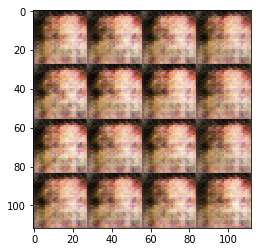

Epoch 1/1,  Batch 420,  Discriminator Loss: 1.0450,  Generator Loss: 0.9951
Epoch 1/1,  Batch 440,  Discriminator Loss: 1.1555,  Generator Loss: 0.9580
Epoch 1/1,  Batch 460,  Discriminator Loss: 1.1530,  Generator Loss: 0.8894
Epoch 1/1,  Batch 480,  Discriminator Loss: 1.0464,  Generator Loss: 1.0464
Epoch 1/1,  Batch 500,  Discriminator Loss: 0.9387,  Generator Loss: 1.1479
Epoch 1/1,  Batch 520,  Discriminator Loss: 1.0993,  Generator Loss: 0.9922
Epoch 1/1,  Batch 540,  Discriminator Loss: 1.2015,  Generator Loss: 0.8304
Epoch 1/1,  Batch 560,  Discriminator Loss: 1.1943,  Generator Loss: 0.8039
Epoch 1/1,  Batch 580,  Discriminator Loss: 1.0485,  Generator Loss: 1.0789
Epoch 1/1,  Batch 600,  Discriminator Loss: 1.0613,  Generator Loss: 0.9478


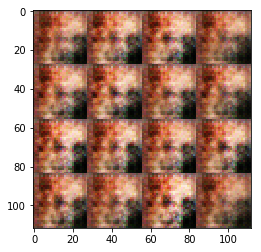

Epoch 1/1,  Batch 620,  Discriminator Loss: 1.2127,  Generator Loss: 0.7566
Epoch 1/1,  Batch 640,  Discriminator Loss: 1.1758,  Generator Loss: 0.8399
Epoch 1/1,  Batch 660,  Discriminator Loss: 1.1345,  Generator Loss: 0.9433
Epoch 1/1,  Batch 680,  Discriminator Loss: 1.0390,  Generator Loss: 0.9810
Epoch 1/1,  Batch 700,  Discriminator Loss: 1.2959,  Generator Loss: 0.8678
Epoch 1/1,  Batch 720,  Discriminator Loss: 1.1240,  Generator Loss: 1.0018
Epoch 1/1,  Batch 740,  Discriminator Loss: 1.1418,  Generator Loss: 0.8912
Epoch 1/1,  Batch 760,  Discriminator Loss: 1.2096,  Generator Loss: 0.9443
Epoch 1/1,  Batch 780,  Discriminator Loss: 1.2892,  Generator Loss: 0.8680
Epoch 1/1,  Batch 800,  Discriminator Loss: 1.3599,  Generator Loss: 0.7652


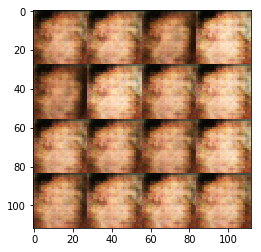

Epoch 1/1,  Batch 820,  Discriminator Loss: 1.2523,  Generator Loss: 0.7746
Epoch 1/1,  Batch 840,  Discriminator Loss: 1.0507,  Generator Loss: 1.0446
Epoch 1/1,  Batch 860,  Discriminator Loss: 1.1446,  Generator Loss: 0.9971
Epoch 1/1,  Batch 880,  Discriminator Loss: 1.1301,  Generator Loss: 1.0151
Epoch 1/1,  Batch 900,  Discriminator Loss: 1.2594,  Generator Loss: 0.9735
Epoch 1/1,  Batch 920,  Discriminator Loss: 1.1825,  Generator Loss: 0.8548
Epoch 1/1,  Batch 940,  Discriminator Loss: 1.1660,  Generator Loss: 0.9664
Epoch 1/1,  Batch 960,  Discriminator Loss: 1.1479,  Generator Loss: 0.9566
Epoch 1/1,  Batch 980,  Discriminator Loss: 1.4246,  Generator Loss: 0.8596
Epoch 1/1,  Batch 1000,  Discriminator Loss: 1.1967,  Generator Loss: 0.9228


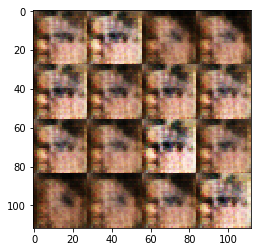

Epoch 1/1,  Batch 1020,  Discriminator Loss: 1.2366,  Generator Loss: 0.8914
Epoch 1/1,  Batch 1040,  Discriminator Loss: 1.1876,  Generator Loss: 0.8508
Epoch 1/1,  Batch 1060,  Discriminator Loss: 1.2860,  Generator Loss: 0.8441
Epoch 1/1,  Batch 1080,  Discriminator Loss: 1.2521,  Generator Loss: 0.8111
Epoch 1/1,  Batch 1100,  Discriminator Loss: 1.2395,  Generator Loss: 0.8700
Epoch 1/1,  Batch 1120,  Discriminator Loss: 1.0960,  Generator Loss: 0.9458
Epoch 1/1,  Batch 1140,  Discriminator Loss: 1.2760,  Generator Loss: 0.9042
Epoch 1/1,  Batch 1160,  Discriminator Loss: 1.3205,  Generator Loss: 0.7457
Epoch 1/1,  Batch 1180,  Discriminator Loss: 1.2080,  Generator Loss: 0.9757
Epoch 1/1,  Batch 1200,  Discriminator Loss: 1.3846,  Generator Loss: 0.8140


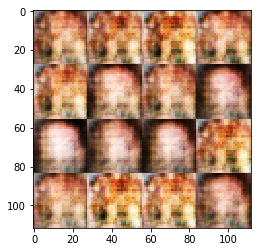

Epoch 1/1,  Batch 1220,  Discriminator Loss: 1.2923,  Generator Loss: 0.8330
Epoch 1/1,  Batch 1240,  Discriminator Loss: 1.2551,  Generator Loss: 0.9128
Epoch 1/1,  Batch 1260,  Discriminator Loss: 1.3736,  Generator Loss: 0.7261
Epoch 1/1,  Batch 1280,  Discriminator Loss: 1.3979,  Generator Loss: 0.8094
Epoch 1/1,  Batch 1300,  Discriminator Loss: 1.3001,  Generator Loss: 0.8490
Epoch 1/1,  Batch 1320,  Discriminator Loss: 1.3053,  Generator Loss: 0.7726
Epoch 1/1,  Batch 1340,  Discriminator Loss: 1.3989,  Generator Loss: 0.7293
Epoch 1/1,  Batch 1360,  Discriminator Loss: 1.2719,  Generator Loss: 0.7873
Epoch 1/1,  Batch 1380,  Discriminator Loss: 1.3699,  Generator Loss: 0.7194
Epoch 1/1,  Batch 1400,  Discriminator Loss: 1.3202,  Generator Loss: 0.8933


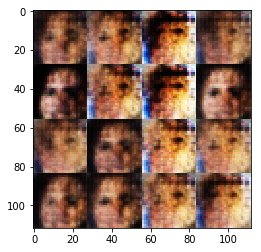

Epoch 1/1,  Batch 1420,  Discriminator Loss: 1.2976,  Generator Loss: 0.7623
Epoch 1/1,  Batch 1440,  Discriminator Loss: 1.3839,  Generator Loss: 0.7661
Epoch 1/1,  Batch 1460,  Discriminator Loss: 1.3030,  Generator Loss: 0.7677
Epoch 1/1,  Batch 1480,  Discriminator Loss: 1.3124,  Generator Loss: 0.8007
Epoch 1/1,  Batch 1500,  Discriminator Loss: 1.4622,  Generator Loss: 0.6960
Epoch 1/1,  Batch 1520,  Discriminator Loss: 1.3558,  Generator Loss: 0.8027
Epoch 1/1,  Batch 1540,  Discriminator Loss: 1.3056,  Generator Loss: 0.8909
Epoch 1/1,  Batch 1560,  Discriminator Loss: 1.4683,  Generator Loss: 0.7659
Epoch 1/1,  Batch 1580,  Discriminator Loss: 1.3037,  Generator Loss: 0.8782
Epoch 1/1,  Batch 1600,  Discriminator Loss: 1.2935,  Generator Loss: 0.8157


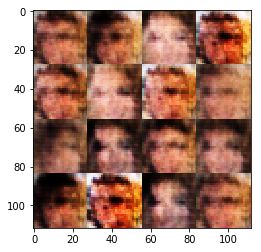

Epoch 1/1,  Batch 1620,  Discriminator Loss: 1.3231,  Generator Loss: 0.8135
Epoch 1/1,  Batch 1640,  Discriminator Loss: 1.3681,  Generator Loss: 0.7661
Epoch 1/1,  Batch 1660,  Discriminator Loss: 1.3135,  Generator Loss: 0.7631
Epoch 1/1,  Batch 1680,  Discriminator Loss: 1.4353,  Generator Loss: 0.7438
Epoch 1/1,  Batch 1700,  Discriminator Loss: 1.4172,  Generator Loss: 0.7737
Epoch 1/1,  Batch 1720,  Discriminator Loss: 1.4078,  Generator Loss: 0.7447
Epoch 1/1,  Batch 1740,  Discriminator Loss: 1.4183,  Generator Loss: 0.7483
Epoch 1/1,  Batch 1760,  Discriminator Loss: 1.4357,  Generator Loss: 0.6906
Epoch 1/1,  Batch 1780,  Discriminator Loss: 1.3565,  Generator Loss: 0.7715
Epoch 1/1,  Batch 1800,  Discriminator Loss: 1.3546,  Generator Loss: 0.8046


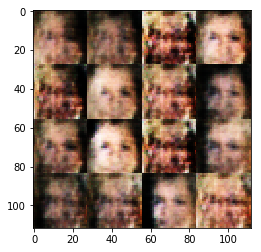

Epoch 1/1,  Batch 1820,  Discriminator Loss: 1.4264,  Generator Loss: 0.7262
Epoch 1/1,  Batch 1840,  Discriminator Loss: 1.3825,  Generator Loss: 0.7181
Epoch 1/1,  Batch 1860,  Discriminator Loss: 1.4414,  Generator Loss: 0.7496
Epoch 1/1,  Batch 1880,  Discriminator Loss: 1.3784,  Generator Loss: 0.7179
Epoch 1/1,  Batch 1900,  Discriminator Loss: 1.3582,  Generator Loss: 0.8115
Epoch 1/1,  Batch 1920,  Discriminator Loss: 1.3827,  Generator Loss: 0.7785
Epoch 1/1,  Batch 1940,  Discriminator Loss: 1.3369,  Generator Loss: 0.8320
Epoch 1/1,  Batch 1960,  Discriminator Loss: 1.4447,  Generator Loss: 0.7687
Epoch 1/1,  Batch 1980,  Discriminator Loss: 1.3588,  Generator Loss: 0.7956
Epoch 1/1,  Batch 2000,  Discriminator Loss: 1.5835,  Generator Loss: 0.8416


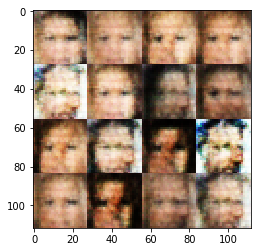

Epoch 1/1,  Batch 2020,  Discriminator Loss: 1.3448,  Generator Loss: 0.8033
Epoch 1/1,  Batch 2040,  Discriminator Loss: 1.4454,  Generator Loss: 0.7459
Epoch 1/1,  Batch 2060,  Discriminator Loss: 1.4863,  Generator Loss: 0.6998
Epoch 1/1,  Batch 2080,  Discriminator Loss: 1.4304,  Generator Loss: 0.7338
Epoch 1/1,  Batch 2100,  Discriminator Loss: 1.4343,  Generator Loss: 0.7297
Epoch 1/1,  Batch 2120,  Discriminator Loss: 1.5415,  Generator Loss: 0.6806
Epoch 1/1,  Batch 2140,  Discriminator Loss: 1.4049,  Generator Loss: 0.7670
Epoch 1/1,  Batch 2160,  Discriminator Loss: 1.3905,  Generator Loss: 0.6971
Epoch 1/1,  Batch 2180,  Discriminator Loss: 1.4563,  Generator Loss: 0.7220
Epoch 1/1,  Batch 2200,  Discriminator Loss: 1.4279,  Generator Loss: 0.7578


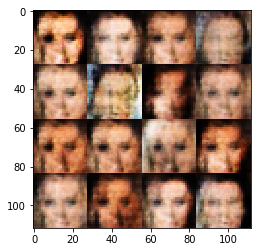

Epoch 1/1,  Batch 2220,  Discriminator Loss: 1.4078,  Generator Loss: 0.7004
Epoch 1/1,  Batch 2240,  Discriminator Loss: 1.4597,  Generator Loss: 0.7178
Epoch 1/1,  Batch 2260,  Discriminator Loss: 1.3858,  Generator Loss: 0.6957
Epoch 1/1,  Batch 2280,  Discriminator Loss: 1.4565,  Generator Loss: 0.7264
Epoch 1/1,  Batch 2300,  Discriminator Loss: 1.4200,  Generator Loss: 0.7196
Epoch 1/1,  Batch 2320,  Discriminator Loss: 1.4572,  Generator Loss: 0.6950
Epoch 1/1,  Batch 2340,  Discriminator Loss: 1.4802,  Generator Loss: 0.7788
Epoch 1/1,  Batch 2360,  Discriminator Loss: 1.4312,  Generator Loss: 0.7311
Epoch 1/1,  Batch 2380,  Discriminator Loss: 1.4403,  Generator Loss: 0.8109
Epoch 1/1,  Batch 2400,  Discriminator Loss: 1.4077,  Generator Loss: 0.7523


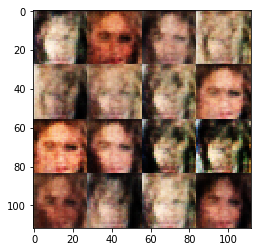

Epoch 1/1,  Batch 2420,  Discriminator Loss: 1.3717,  Generator Loss: 0.7809
Epoch 1/1,  Batch 2440,  Discriminator Loss: 1.4823,  Generator Loss: 0.6648
Epoch 1/1,  Batch 2460,  Discriminator Loss: 1.3710,  Generator Loss: 0.7596
Epoch 1/1,  Batch 2480,  Discriminator Loss: 1.3429,  Generator Loss: 0.7691
Epoch 1/1,  Batch 2500,  Discriminator Loss: 1.4385,  Generator Loss: 0.7306
Epoch 1/1,  Batch 2520,  Discriminator Loss: 1.3240,  Generator Loss: 0.8469
Epoch 1/1,  Batch 2540,  Discriminator Loss: 1.4396,  Generator Loss: 0.7402
Epoch 1/1,  Batch 2560,  Discriminator Loss: 1.3806,  Generator Loss: 0.7547
Epoch 1/1,  Batch 2580,  Discriminator Loss: 1.3275,  Generator Loss: 0.7815
Epoch 1/1,  Batch 2600,  Discriminator Loss: 1.3961,  Generator Loss: 0.7625


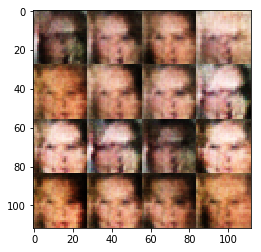

Epoch 1/1,  Batch 2620,  Discriminator Loss: 1.4244,  Generator Loss: 0.7225
Epoch 1/1,  Batch 2640,  Discriminator Loss: 1.4325,  Generator Loss: 0.7570
Epoch 1/1,  Batch 2660,  Discriminator Loss: 1.4764,  Generator Loss: 0.6520
Epoch 1/1,  Batch 2680,  Discriminator Loss: 1.4157,  Generator Loss: 0.7596
Epoch 1/1,  Batch 2700,  Discriminator Loss: 1.3618,  Generator Loss: 0.7792
Epoch 1/1,  Batch 2720,  Discriminator Loss: 1.3601,  Generator Loss: 0.7718
Epoch 1/1,  Batch 2740,  Discriminator Loss: 1.4947,  Generator Loss: 0.6821
Epoch 1/1,  Batch 2760,  Discriminator Loss: 1.4297,  Generator Loss: 0.8299
Epoch 1/1,  Batch 2780,  Discriminator Loss: 1.3877,  Generator Loss: 0.7504
Epoch 1/1,  Batch 2800,  Discriminator Loss: 1.4265,  Generator Loss: 0.7731


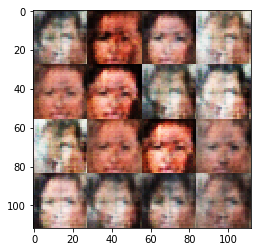

Epoch 1/1,  Batch 2820,  Discriminator Loss: 1.4008,  Generator Loss: 0.7210
Epoch 1/1,  Batch 2840,  Discriminator Loss: 1.4121,  Generator Loss: 0.8682
Epoch 1/1,  Batch 2860,  Discriminator Loss: 1.4041,  Generator Loss: 0.7598
Epoch 1/1,  Batch 2880,  Discriminator Loss: 1.4105,  Generator Loss: 0.7906
Epoch 1/1,  Batch 2900,  Discriminator Loss: 1.3420,  Generator Loss: 0.8327
Epoch 1/1,  Batch 2920,  Discriminator Loss: 1.4412,  Generator Loss: 0.7459
Epoch 1/1,  Batch 2940,  Discriminator Loss: 1.3966,  Generator Loss: 0.7516
Epoch 1/1,  Batch 2960,  Discriminator Loss: 1.4934,  Generator Loss: 0.6717
Epoch 1/1,  Batch 2980,  Discriminator Loss: 1.3266,  Generator Loss: 0.8331
Epoch 1/1,  Batch 3000,  Discriminator Loss: 1.3584,  Generator Loss: 0.7678


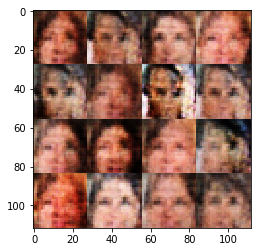

Epoch 1/1,  Batch 3020,  Discriminator Loss: 1.3957,  Generator Loss: 0.7573
Epoch 1/1,  Batch 3040,  Discriminator Loss: 1.3940,  Generator Loss: 0.7448
Epoch 1/1,  Batch 3060,  Discriminator Loss: 1.3939,  Generator Loss: 0.7571
Epoch 1/1,  Batch 3080,  Discriminator Loss: 1.4839,  Generator Loss: 0.7609
Epoch 1/1,  Batch 3100,  Discriminator Loss: 1.3438,  Generator Loss: 0.7719
Epoch 1/1,  Batch 3120,  Discriminator Loss: 1.3754,  Generator Loss: 0.7455
Epoch 1/1,  Batch 3140,  Discriminator Loss: 1.3450,  Generator Loss: 0.8454
Epoch 1/1,  Batch 3160,  Discriminator Loss: 1.4129,  Generator Loss: 0.7349
Epoch 1/1,  Batch 3180,  Discriminator Loss: 1.4161,  Generator Loss: 0.7725
Epoch 1/1,  Batch 3200,  Discriminator Loss: 1.4455,  Generator Loss: 0.7384


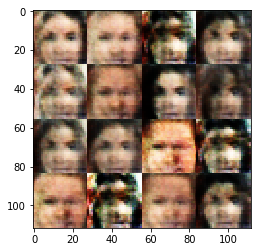

Epoch 1/1,  Batch 3220,  Discriminator Loss: 1.3343,  Generator Loss: 0.7916
Epoch 1/1,  Batch 3240,  Discriminator Loss: 1.4138,  Generator Loss: 0.7455
Epoch 1/1,  Batch 3260,  Discriminator Loss: 1.3592,  Generator Loss: 0.7724
Epoch 1/1,  Batch 3280,  Discriminator Loss: 1.3735,  Generator Loss: 0.7971
Epoch 1/1,  Batch 3300,  Discriminator Loss: 1.3577,  Generator Loss: 0.8211
Epoch 1/1,  Batch 3320,  Discriminator Loss: 1.4212,  Generator Loss: 0.7423
Epoch 1/1,  Batch 3340,  Discriminator Loss: 1.3253,  Generator Loss: 0.7799
Epoch 1/1,  Batch 3360,  Discriminator Loss: 1.4231,  Generator Loss: 0.7513
Epoch 1/1,  Batch 3380,  Discriminator Loss: 1.4620,  Generator Loss: 0.7784
Epoch 1/1,  Batch 3400,  Discriminator Loss: 1.3566,  Generator Loss: 0.8205


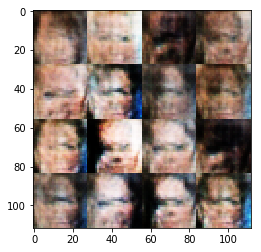

Epoch 1/1,  Batch 3420,  Discriminator Loss: 1.3933,  Generator Loss: 0.8050
Epoch 1/1,  Batch 3440,  Discriminator Loss: 1.4021,  Generator Loss: 0.7577
Epoch 1/1,  Batch 3460,  Discriminator Loss: 1.4697,  Generator Loss: 0.7299
Epoch 1/1,  Batch 3480,  Discriminator Loss: 1.4543,  Generator Loss: 0.6958
Epoch 1/1,  Batch 3500,  Discriminator Loss: 1.4158,  Generator Loss: 0.7390
Epoch 1/1,  Batch 3520,  Discriminator Loss: 1.3895,  Generator Loss: 0.7838
Epoch 1/1,  Batch 3540,  Discriminator Loss: 1.4063,  Generator Loss: 0.7095
Epoch 1/1,  Batch 3560,  Discriminator Loss: 1.3908,  Generator Loss: 0.7508
Epoch 1/1,  Batch 3580,  Discriminator Loss: 1.4587,  Generator Loss: 0.7259
Epoch 1/1,  Batch 3600,  Discriminator Loss: 1.4298,  Generator Loss: 0.7272


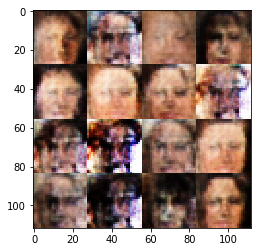

Epoch 1/1,  Batch 3620,  Discriminator Loss: 1.4574,  Generator Loss: 0.7294
Epoch 1/1,  Batch 3640,  Discriminator Loss: 1.3746,  Generator Loss: 0.8397
Epoch 1/1,  Batch 3660,  Discriminator Loss: 1.3974,  Generator Loss: 0.7316
Epoch 1/1,  Batch 3680,  Discriminator Loss: 1.3946,  Generator Loss: 0.8165
Epoch 1/1,  Batch 3700,  Discriminator Loss: 1.4318,  Generator Loss: 0.7640
Epoch 1/1,  Batch 3720,  Discriminator Loss: 1.3894,  Generator Loss: 0.7479
Epoch 1/1,  Batch 3740,  Discriminator Loss: 1.4386,  Generator Loss: 0.8272
Epoch 1/1,  Batch 3760,  Discriminator Loss: 1.3867,  Generator Loss: 0.7631
Epoch 1/1,  Batch 3780,  Discriminator Loss: 1.4488,  Generator Loss: 0.7812
Epoch 1/1,  Batch 3800,  Discriminator Loss: 1.4330,  Generator Loss: 0.7203


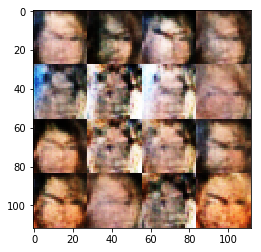

Epoch 1/1,  Batch 3820,  Discriminator Loss: 1.2934,  Generator Loss: 0.8572
Epoch 1/1,  Batch 3840,  Discriminator Loss: 1.3614,  Generator Loss: 0.7535
Epoch 1/1,  Batch 3860,  Discriminator Loss: 1.3862,  Generator Loss: 0.8164
Epoch 1/1,  Batch 3880,  Discriminator Loss: 1.3649,  Generator Loss: 0.7648
Epoch 1/1,  Batch 3900,  Discriminator Loss: 1.4186,  Generator Loss: 0.7674
Epoch 1/1,  Batch 3920,  Discriminator Loss: 1.4305,  Generator Loss: 0.7727
Epoch 1/1,  Batch 3940,  Discriminator Loss: 1.3841,  Generator Loss: 0.7388
Epoch 1/1,  Batch 3960,  Discriminator Loss: 1.3740,  Generator Loss: 0.7863
Epoch 1/1,  Batch 3980,  Discriminator Loss: 1.4081,  Generator Loss: 0.7464
Epoch 1/1,  Batch 4000,  Discriminator Loss: 1.3582,  Generator Loss: 0.7994


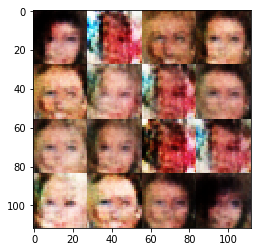

Epoch 1/1,  Batch 4020,  Discriminator Loss: 1.4416,  Generator Loss: 0.7137
Epoch 1/1,  Batch 4040,  Discriminator Loss: 1.4223,  Generator Loss: 0.7125
Epoch 1/1,  Batch 4060,  Discriminator Loss: 1.3315,  Generator Loss: 0.8145
Epoch 1/1,  Batch 4080,  Discriminator Loss: 1.4426,  Generator Loss: 0.7429
Epoch 1/1,  Batch 4100,  Discriminator Loss: 1.4234,  Generator Loss: 0.7445
Epoch 1/1,  Batch 4120,  Discriminator Loss: 1.3579,  Generator Loss: 0.7710
Epoch 1/1,  Batch 4140,  Discriminator Loss: 1.4441,  Generator Loss: 0.7130
Epoch 1/1,  Batch 4160,  Discriminator Loss: 1.4700,  Generator Loss: 0.7899
Epoch 1/1,  Batch 4180,  Discriminator Loss: 1.3743,  Generator Loss: 0.7806
Epoch 1/1,  Batch 4200,  Discriminator Loss: 1.4074,  Generator Loss: 0.7413


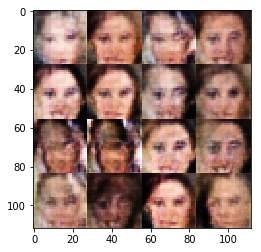

Epoch 1/1,  Batch 4220,  Discriminator Loss: 1.4146,  Generator Loss: 0.7493
Epoch 1/1,  Batch 4240,  Discriminator Loss: 1.4507,  Generator Loss: 0.7265
Epoch 1/1,  Batch 4260,  Discriminator Loss: 1.3754,  Generator Loss: 0.7829
Epoch 1/1,  Batch 4280,  Discriminator Loss: 1.4352,  Generator Loss: 0.7141
Epoch 1/1,  Batch 4300,  Discriminator Loss: 1.4043,  Generator Loss: 0.7580
Epoch 1/1,  Batch 4320,  Discriminator Loss: 1.4530,  Generator Loss: 0.7336
Epoch 1/1,  Batch 4340,  Discriminator Loss: 1.3491,  Generator Loss: 0.7976
Epoch 1/1,  Batch 4360,  Discriminator Loss: 1.4291,  Generator Loss: 0.7674
Epoch 1/1,  Batch 4380,  Discriminator Loss: 1.4316,  Generator Loss: 0.7404
Epoch 1/1,  Batch 4400,  Discriminator Loss: 1.3383,  Generator Loss: 0.7952


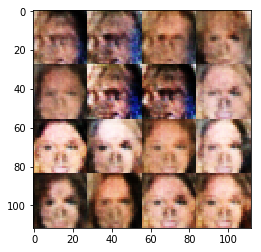

Epoch 1/1,  Batch 4420,  Discriminator Loss: 1.3814,  Generator Loss: 0.7346
Epoch 1/1,  Batch 4440,  Discriminator Loss: 1.4679,  Generator Loss: 0.7275
Epoch 1/1,  Batch 4460,  Discriminator Loss: 1.3919,  Generator Loss: 0.7317
Epoch 1/1,  Batch 4480,  Discriminator Loss: 1.3619,  Generator Loss: 0.7618
Epoch 1/1,  Batch 4500,  Discriminator Loss: 1.3882,  Generator Loss: 0.7608
Epoch 1/1,  Batch 4520,  Discriminator Loss: 1.4295,  Generator Loss: 0.7101
Epoch 1/1,  Batch 4540,  Discriminator Loss: 1.4052,  Generator Loss: 0.7379
Epoch 1/1,  Batch 4560,  Discriminator Loss: 1.4239,  Generator Loss: 0.7913
Epoch 1/1,  Batch 4580,  Discriminator Loss: 1.4746,  Generator Loss: 0.6741
Epoch 1/1,  Batch 4600,  Discriminator Loss: 1.4373,  Generator Loss: 0.7496


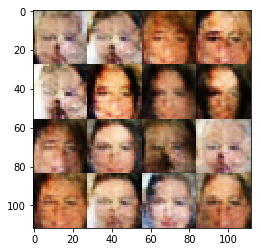

Epoch 1/1,  Batch 4620,  Discriminator Loss: 1.4199,  Generator Loss: 0.7551
Epoch 1/1,  Batch 4640,  Discriminator Loss: 1.3696,  Generator Loss: 0.7467
Epoch 1/1,  Batch 4660,  Discriminator Loss: 1.3755,  Generator Loss: 0.7629
Epoch 1/1,  Batch 4680,  Discriminator Loss: 1.4121,  Generator Loss: 0.7765
Epoch 1/1,  Batch 4700,  Discriminator Loss: 1.3751,  Generator Loss: 0.7951
Epoch 1/1,  Batch 4720,  Discriminator Loss: 1.4264,  Generator Loss: 0.7563
Epoch 1/1,  Batch 4740,  Discriminator Loss: 1.4223,  Generator Loss: 0.7741
Epoch 1/1,  Batch 4760,  Discriminator Loss: 1.4689,  Generator Loss: 0.6770
Epoch 1/1,  Batch 4780,  Discriminator Loss: 1.3699,  Generator Loss: 0.7510
Epoch 1/1,  Batch 4800,  Discriminator Loss: 1.3897,  Generator Loss: 0.7787


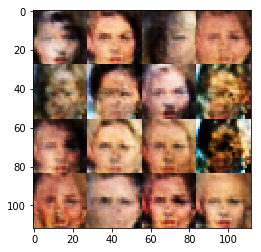

Epoch 1/1,  Batch 4820,  Discriminator Loss: 1.3670,  Generator Loss: 0.7862
Epoch 1/1,  Batch 4840,  Discriminator Loss: 1.3884,  Generator Loss: 0.7933
Epoch 1/1,  Batch 4860,  Discriminator Loss: 1.4279,  Generator Loss: 0.7397
Epoch 1/1,  Batch 4880,  Discriminator Loss: 1.4351,  Generator Loss: 0.7306
Epoch 1/1,  Batch 4900,  Discriminator Loss: 1.3857,  Generator Loss: 0.7794
Epoch 1/1,  Batch 4920,  Discriminator Loss: 1.4104,  Generator Loss: 0.7492
Epoch 1/1,  Batch 4940,  Discriminator Loss: 1.4251,  Generator Loss: 0.7947
Epoch 1/1,  Batch 4960,  Discriminator Loss: 1.4750,  Generator Loss: 0.6655
Epoch 1/1,  Batch 4980,  Discriminator Loss: 1.3990,  Generator Loss: 0.7470
Epoch 1/1,  Batch 5000,  Discriminator Loss: 1.4219,  Generator Loss: 0.7378


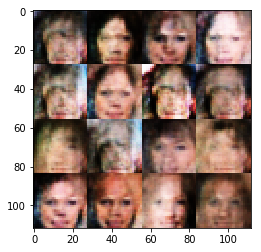

Epoch 1/1,  Batch 5020,  Discriminator Loss: 1.4320,  Generator Loss: 0.7190
Epoch 1/1,  Batch 5040,  Discriminator Loss: 1.4380,  Generator Loss: 0.7498
Epoch 1/1,  Batch 5060,  Discriminator Loss: 1.4394,  Generator Loss: 0.7205
Epoch 1/1,  Batch 5080,  Discriminator Loss: 1.4200,  Generator Loss: 0.7350
Epoch 1/1,  Batch 5100,  Discriminator Loss: 1.4246,  Generator Loss: 0.7570
Epoch 1/1,  Batch 5120,  Discriminator Loss: 1.4566,  Generator Loss: 0.7919
Epoch 1/1,  Batch 5140,  Discriminator Loss: 1.4349,  Generator Loss: 0.7232
Epoch 1/1,  Batch 5160,  Discriminator Loss: 1.4243,  Generator Loss: 0.7809
Epoch 1/1,  Batch 5180,  Discriminator Loss: 1.4439,  Generator Loss: 0.7313
Epoch 1/1,  Batch 5200,  Discriminator Loss: 1.4199,  Generator Loss: 0.7974


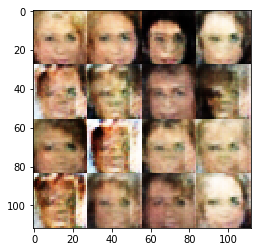

Epoch 1/1,  Batch 5220,  Discriminator Loss: 1.4153,  Generator Loss: 0.7418
Epoch 1/1,  Batch 5240,  Discriminator Loss: 1.4174,  Generator Loss: 0.7469
Epoch 1/1,  Batch 5260,  Discriminator Loss: 1.4422,  Generator Loss: 0.7235
Epoch 1/1,  Batch 5280,  Discriminator Loss: 1.4212,  Generator Loss: 0.7455
Epoch 1/1,  Batch 5300,  Discriminator Loss: 1.3954,  Generator Loss: 0.7988
Epoch 1/1,  Batch 5320,  Discriminator Loss: 1.3958,  Generator Loss: 0.7382
Epoch 1/1,  Batch 5340,  Discriminator Loss: 1.4317,  Generator Loss: 0.7955
Epoch 1/1,  Batch 5360,  Discriminator Loss: 1.3437,  Generator Loss: 0.7407
Epoch 1/1,  Batch 5380,  Discriminator Loss: 1.3933,  Generator Loss: 0.8081
Epoch 1/1,  Batch 5400,  Discriminator Loss: 1.4105,  Generator Loss: 0.8284


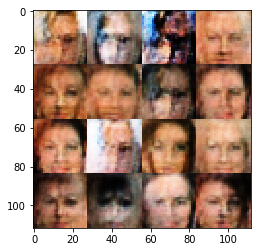

Epoch 1/1,  Batch 5420,  Discriminator Loss: 1.4376,  Generator Loss: 0.7349
Epoch 1/1,  Batch 5440,  Discriminator Loss: 1.3847,  Generator Loss: 0.7906
Epoch 1/1,  Batch 5460,  Discriminator Loss: 1.3368,  Generator Loss: 0.8058
Epoch 1/1,  Batch 5480,  Discriminator Loss: 1.3845,  Generator Loss: 0.7664
Epoch 1/1,  Batch 5500,  Discriminator Loss: 1.4077,  Generator Loss: 0.7661
Epoch 1/1,  Batch 5520,  Discriminator Loss: 1.3852,  Generator Loss: 0.7989
Epoch 1/1,  Batch 5540,  Discriminator Loss: 1.3654,  Generator Loss: 0.7946
Epoch 1/1,  Batch 5560,  Discriminator Loss: 1.4373,  Generator Loss: 0.7442
Epoch 1/1,  Batch 5580,  Discriminator Loss: 1.4052,  Generator Loss: 0.7601
Epoch 1/1,  Batch 5600,  Discriminator Loss: 1.4191,  Generator Loss: 0.7413


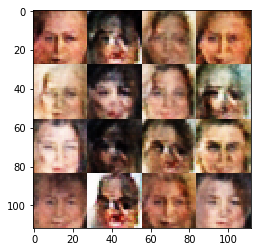

Epoch 1/1,  Batch 5620,  Discriminator Loss: 1.3988,  Generator Loss: 0.7761
Epoch 1/1,  Batch 5640,  Discriminator Loss: 1.4209,  Generator Loss: 0.7297
Epoch 1/1,  Batch 5660,  Discriminator Loss: 1.4544,  Generator Loss: 0.7473
Epoch 1/1,  Batch 5680,  Discriminator Loss: 1.4144,  Generator Loss: 0.7057
Epoch 1/1,  Batch 5700,  Discriminator Loss: 1.3463,  Generator Loss: 0.8013
Epoch 1/1,  Batch 5720,  Discriminator Loss: 1.4112,  Generator Loss: 0.7569
Epoch 1/1,  Batch 5740,  Discriminator Loss: 1.4168,  Generator Loss: 0.7625
Epoch 1/1,  Batch 5760,  Discriminator Loss: 1.4690,  Generator Loss: 0.7013
Epoch 1/1,  Batch 5780,  Discriminator Loss: 1.3846,  Generator Loss: 0.7290
Epoch 1/1,  Batch 5800,  Discriminator Loss: 1.4221,  Generator Loss: 0.7093


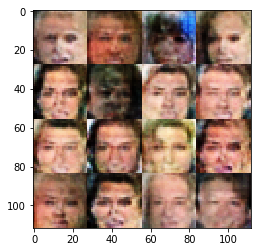

Epoch 1/1,  Batch 5820,  Discriminator Loss: 1.3767,  Generator Loss: 0.7431
Epoch 1/1,  Batch 5840,  Discriminator Loss: 1.4130,  Generator Loss: 0.7540
Epoch 1/1,  Batch 5860,  Discriminator Loss: 1.3955,  Generator Loss: 0.7368
Epoch 1/1,  Batch 5880,  Discriminator Loss: 1.3994,  Generator Loss: 0.7522
Epoch 1/1,  Batch 5900,  Discriminator Loss: 1.4151,  Generator Loss: 0.7315
Epoch 1/1,  Batch 5920,  Discriminator Loss: 1.3675,  Generator Loss: 0.7965
Epoch 1/1,  Batch 5940,  Discriminator Loss: 1.3503,  Generator Loss: 0.7774
Epoch 1/1,  Batch 5960,  Discriminator Loss: 1.4496,  Generator Loss: 0.7381
Epoch 1/1,  Batch 5980,  Discriminator Loss: 1.3592,  Generator Loss: 0.8019
Epoch 1/1,  Batch 6000,  Discriminator Loss: 1.4357,  Generator Loss: 0.7199


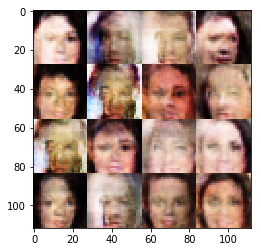

Epoch 1/1,  Batch 6020,  Discriminator Loss: 1.4250,  Generator Loss: 0.7544
Epoch 1/1,  Batch 6040,  Discriminator Loss: 1.4090,  Generator Loss: 0.7422
Epoch 1/1,  Batch 6060,  Discriminator Loss: 1.3470,  Generator Loss: 0.7981
Epoch 1/1,  Batch 6080,  Discriminator Loss: 1.4499,  Generator Loss: 0.7575
Epoch 1/1,  Batch 6100,  Discriminator Loss: 1.3966,  Generator Loss: 0.7402
Epoch 1/1,  Batch 6120,  Discriminator Loss: 1.4170,  Generator Loss: 0.7520
Epoch 1/1,  Batch 6140,  Discriminator Loss: 1.3752,  Generator Loss: 0.7667
Epoch 1/1,  Batch 6160,  Discriminator Loss: 1.4265,  Generator Loss: 0.7813
Epoch 1/1,  Batch 6180,  Discriminator Loss: 1.4287,  Generator Loss: 0.7150
Epoch 1/1,  Batch 6200,  Discriminator Loss: 1.3971,  Generator Loss: 0.7526


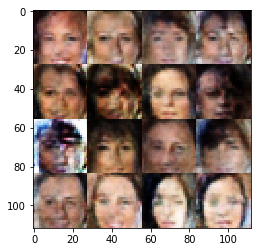

Epoch 1/1,  Batch 6220,  Discriminator Loss: 1.4251,  Generator Loss: 0.7068
Epoch 1/1,  Batch 6240,  Discriminator Loss: 1.3961,  Generator Loss: 0.7767
Epoch 1/1,  Batch 6260,  Discriminator Loss: 1.3952,  Generator Loss: 0.7580
Epoch 1/1,  Batch 6280,  Discriminator Loss: 1.4050,  Generator Loss: 0.7463
Epoch 1/1,  Batch 6300,  Discriminator Loss: 1.4602,  Generator Loss: 0.7213
Epoch 1/1,  Batch 6320,  Discriminator Loss: 1.4364,  Generator Loss: 0.7330


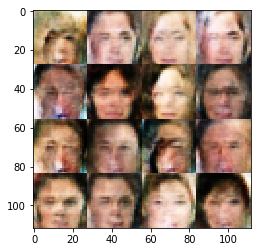

GAN is completed.


In [14]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.